In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import torch
from sbi.utils import BoxUniform

from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import process_simulator, process_prior, check_sbi_inputs


# ground truth

In [2]:
v = 1; a = 1

# sbi

## prior

In [3]:
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent

v_distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))
a_distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))


prior_111 = MultipleIndependent(
    [
        v_distribution,  # drift rate
        a_distribution,  # threshold
    ],
)



prior, num_parameters, prior_returns_numpy = process_prior(prior_111)

In [4]:
print(f' prior: {prior} , num_parameters: {num_parameters} , prior_returns_numpy: {prior_returns_numpy}') 

 prior: MultipleIndependent() , num_parameters: 2 , prior_returns_numpy: False


## simulate single bound

In [32]:
def simulate_PA(params):
    num_trials = params.shape[0]
    output = np.zeros((num_trials))

    for trial in range(num_trials):
        v = params[trial, 0]
        a = params[trial, 1]

        dt = 1e-3; dB = np.sqrt(dt)
        DV = 0; t = 0
        while True:
            DV += v*dt + np.random.normal(0, dB)
            t += dt

            if DV >= a:
                output[trial] = t
                break
                
    
    return torch.from_numpy(output).to(dtype=torch.float32)


## sbi simulator

In [6]:
simulator = process_simulator(simulate_PA, prior, prior_returns_numpy)

In [7]:
check_sbi_inputs(simulator, prior)

IndexError: too many indices for tensor of dimension 1

In [10]:
N_sim = int(50e3)

theta, x_o = simulate_for_sbi(simulator=simulate_PA,\
                            proposal=prior,
                            num_simulations=N_sim,
                            num_workers=32)

  0%|          | 0/50000 [00:00<?, ?it/s]

## train network

In [11]:
# from sbi.inference import MNLE
# trainer = MNLE()

from sbi.inference import SNLE
trainer = SNLE()

print(f'theta shape = {theta.shape}, x_o shape = {x_o.shape}')  
estimator = trainer.append_simulations(theta, x_o.reshape(-1,1)).train(training_batch_size=1000)

theta shape = torch.Size([50000, 2]), x_o shape = torch.Size([50000])


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 83 epochs.

## likelihood

In [12]:
bin_width = 0.05
bins = np.arange(0, 4, bin_width)
t_pts = bins[:-1] + bin_width/2
t_pts_tensor = torch.tensor(t_pts).unsqueeze(0).T.to(dtype=torch.float32)

params = torch.tensor([[v,a]]).repeat(len(t_pts),1)

print(f't_pts_tensor shape = {t_pts_tensor.shape}, params shape = {params.shape}')

loglike = estimator.log_prob(t_pts_tensor.T, params)
like = torch.exp(loglike)

t_pts_tensor shape = torch.Size([79, 1]), params shape = torch.Size([79, 2])


In [ ]:
from joblib import Parallel, delayed

def simulate_PA_2(params):
    v,a = params
    dt = 1e-4; dB = 1e-2
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t

sim_results = Parallel(n_jobs=-1)(delayed(simulate_PA_2)([v,a]) for _ in range(int(50e3)))

In [17]:
params_1 = params

In [34]:
params_rep = params_1.repeat(100,1)

In [ ]:
simulated_from_simulate_pa = simulate_PA(params_rep)

In [39]:
q = simulated_from_simulate_pa.numpy().shape

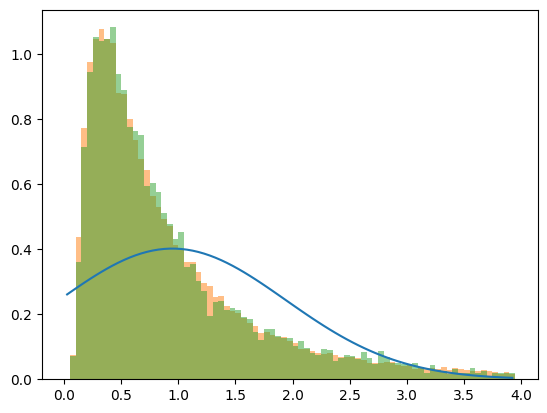

In [40]:
plt.plot(t_pts, like.squeeze().detach().numpy())
plt.hist(sim_results, bins=bins, density=True, alpha=0.5);
plt.hist(simulated_from_simulate_pa.numpy(), bins=bins, density=True, alpha=0.5);